Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3553 - loss: 1.9066 
Epoch 1: val_loss improved from inf to 0.94147, saving model to chestmodel_swintransformer.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 264s 12s/step - accuracy: 0.3597 - loss: 1.8835 - val_accuracy: 0.5417 - val_loss: 0.9415
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6374 - loss: 0.8285 
Epoch 2: val_loss improved from 0.94147 to 0.83089, saving model to chestmodel_swintransformer.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 237s 11s/step - accuracy: 0.6365 - loss: 0.8296 - val_accuracy: 0.7361 - val_loss: 0.8309
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6661 - loss: 0.7804 
Epoch 3: val_loss improved from 0.83089 to 0.77310, saving model 

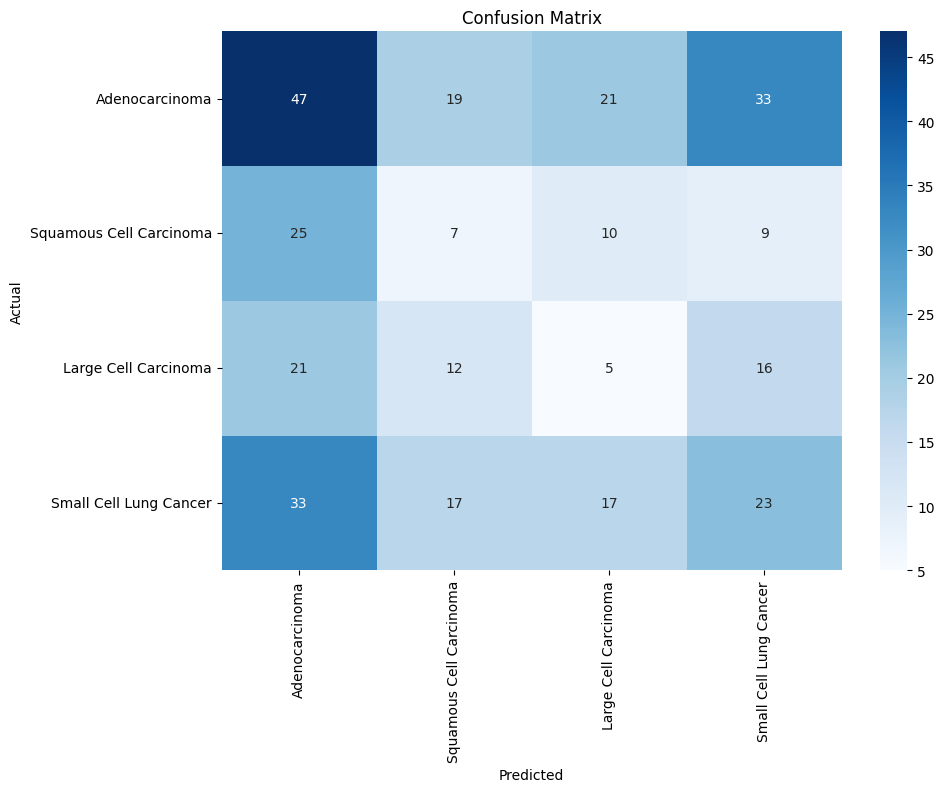

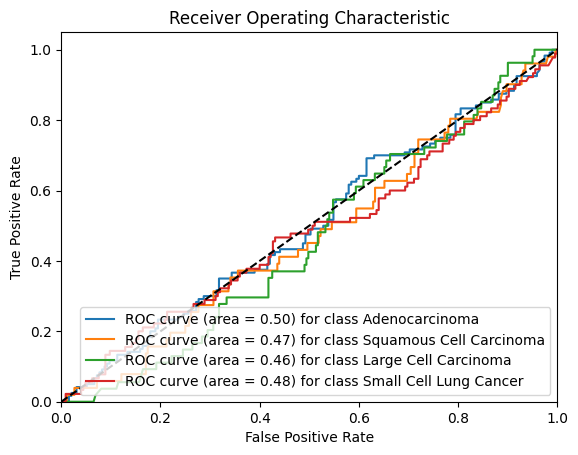

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


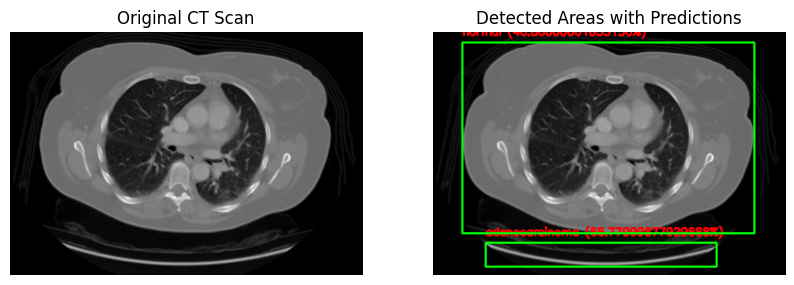

Detected area 1: adenocarcinoma with confidence 66.77999877929688%
Detected area 2: normal with confidence 46.86000061035156%
Final prediction result using Swin Transformer: adenocarcinoma with confidence 66.77999877929688%
Cancer detected by Swin Transformer: adenocarcinoma with confidence 66.77999877929688%
The image is classified as: adenocarcinoma with confidence 66.77999877929688% by Swin Transformer


In [7]:
# -*- coding: utf-8 -*-
"""SwinTransformer.ipynb

Adapted for Swin Transformer by Grok 3 (xAI).
"""

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow_hub as hub

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
train_path = "/content/drive/MyDrive/Data/train"
valid_path = "/content/drive/MyDrive/Data/valid"
test_path = "/content/drive/MyDrive/Data/test"

# Constants
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 32
MODEL_NAME = "Swin Transformer"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    dtype='float32'
)
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

valid_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
valid_generator = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

test_datagen = ImageDataGenerator(dtype='float32', rescale=1.0/255.0)
test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

test_class_names = test_generator.class_names

# Convert grayscale to RGB function
def convert_to_rgb(images):
    return tf.image.grayscale_to_rgb(images) if images.shape[-1] == 1 else images

# Custom layer to wrap hub.KerasLayer
class SwinTransformerLayer(Layer):
    def __init__(self, hub_url, **kwargs):
        super(SwinTransformerLayer, self).__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=False)

    def call(self, inputs, training=None):
        return self.hub_layer(inputs)

# Build Swin Transformer model
def build_swin_transformer_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=N_CLASSES):
    # Define input
    inputs = Input(shape=input_shape)

    # Load Swin Transformer as a custom layer
    swin_transformer_url = "https://tfhub.dev/sayakpaul/swin_tiny_patch4_window7_224/1"  # Example URL
    x = SwinTransformerLayer(swin_transformer_url)(inputs)

    # Add custom top layers (no GlobalAveragePooling2D since output is already 2D)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
model = build_swin_transformer_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint('chestmodel_swintransformer.keras', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_generator.map(lambda x, y: (convert_to_rgb(x), y)),
    epochs=50,
    validation_data=valid_generator.map(lambda x, y: (convert_to_rgb(x), y)),
    callbacks=[checkpointer, early_stopping]
)

# Evaluate the model
train_result = model.evaluate(train_generator.map(lambda x, y: (convert_to_rgb(x), y)))
print(f'Training Loss: {train_result[0]}, Training Accuracy: {train_result[1]}')

test_result = model.evaluate(test_generator.map(lambda x, y: (convert_to_rgb(x), y)))
print(f'Test Loss: {test_result[0]}, Test Accuracy: {test_result[1]}')

# Predictions and Evaluation
y_true = []
for _, labels in test_generator:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

y_pred = model.predict(test_generator.map(lambda x, y: (convert_to_rgb(x), y)))
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Adenocarcinoma', 'Squamous Cell Carcinoma', 'Large Cell Carcinoma', 'Small Cell Lung Cancer']

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curves
fpr = {}
tpr = {}
roc_auc = {}
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(N_CLASSES):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], class_names[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# CT Scan analysis with Swin Transformer
classifier = tf.keras.models.load_model('chestmodel_swintransformer.keras', custom_objects={'SwinTransformerLayer': SwinTransformerLayer})
class_labels = ['adenocarcinoma', 'large_cell_carcinoma', 'normal', 'squamous_cell_carcinoma']

# Function to preprocess the image for prediction
def preprocess_for_prediction(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype('float32') / 255.0  # Simple normalization for Swin Transformer
    img = np.expand_dims(img, axis=0)
    return img

# Load the CT scan image
image_path = '/content/drive/MyDrive/Data/test/adenocarcinoma/000109 (2).png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: Unable to load the image. Please check the file format and path.")
else:
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    predictions = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cropped_image = image[y:y + h, x:x + w]
            preprocessed_image = preprocess_for_prediction(cropped_image)
            confidence_scores = classifier.predict(preprocessed_image)[0]
            predicted_class_index = np.argmax(confidence_scores)
            predicted_class = class_labels[predicted_class_index]
            confidence = round(100 * confidence_scores[predicted_class_index], 2)
            predictions.append((predicted_class, confidence))
            cv2.putText(output_image, f"{predicted_class} ({confidence}%)", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original CT Scan')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Detected Areas with Predictions')
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

    # Print individual predictions
    for i, (pred_class, conf) in enumerate(predictions):
        print(f'Detected area {i + 1}: {pred_class} with confidence {conf}%')

    # Detection logic using model name
    if predictions:
        final_pred_class, final_conf = max(predictions, key=lambda x: x[1])
        print(f'Final prediction result using {MODEL_NAME}: '
              f'{final_pred_class} with confidence {final_conf}%')

        cancer_types = ['adenocarcinoma', 'large_cell_carcinoma', 'squamous_cell_carcinoma']
        if final_pred_class.lower() in cancer_types:
            print(f"Cancer detected by {MODEL_NAME}: {final_pred_class} with confidence {final_conf}%")
        else:
            print(f"No cancer detected by {MODEL_NAME}: {final_pred_class} with confidence {final_conf}%")

        print(f"The image is classified as: {final_pred_class} with confidence {final_conf}% "
              f"by {MODEL_NAME}")
    else:
        print("No significant areas detected.")
        print(f"The image type cannot be determined by {MODEL_NAME} due to no detectable areas.")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
